In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import emcee

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

In [2]:
def computeResponse(delta,length,width,time,u,k_0,R):
        """
        Computes concentrations.
        Arguments:
         source == forcing function (shape: Nt x Nx x Ny). Can either be generated by ... or determine manually.
         enforce_nonnegative = default False,. Setting to true will force concentration to be non-negative each iteration.
        returns array of concentrations (shape: Nt x Nx x Ny), given source. (also saved it in self.concentration)
        """
        #source = self.source
        
        #get the grid step sizes, their squares and the size of the grid
        
        dt = delta[0]
        dx = delta[1]
        dy = delta[2]
        dx2 = dx**2
        dy2 = dy**2
        Nt = int(time/dt)
        Nx = int(length/dx)
        Ny = int(width/dy)
        c=np.zeros((Nt,Nx,Ny))
        
        source = np.zeros((Nt,Nx,Ny))
        u=[u[0]*np.ones((Nt,Nx,Ny)),u[1]*np.ones((Nt,Nx,Ny))]
        source[0,int(Nx/10),int(Ny/10)]=1000
        
        c[0,:,:]=0
        for i in range(0,Nt-1):
            # Corner BCs 
            c[i+1,0,0]=c[i,0,0]+dt*( source[i,0,0] ) +dt*k_0*( 2*c[i,1,0]-2*c[i,0,0])/dx2 + dt*k_0*( 2*c[i,0,1]-2*c[i,0,0])/dy2 -dt*R*c[i,0,0]
            c[i+1,Nx-1,Ny-1]=c[i,Nx-1,Ny-1]+dt*( source[i,Nx-1,Ny-1])+dt*k_0*( 2*c[i,Nx-2,Ny-1]-2*c[i,Nx-1,Ny-1])/dx2 + dt*k_0*( 2*c[i,Nx-1,Ny-2]-2*c[i,Nx-1,Ny-1])/dy2-dt*R*c[i,Nx-1,Ny-1]
            c[i+1,0,Ny-1]=c[i,0,Ny-1]+dt*( source[i,0,Ny-1] ) +dt*k_0*( 2*c[i,1,Ny-1]-2*c[i,0,Ny-1])/dx2 + dt*k_0*( 2*c[i,0,Ny-2]-2*c[i,0,Ny-1])/dy2-dt*R*c[i,0,Ny-1]
            c[i+1,Nx-1,0]=c[i,Nx-1,0]+dt*( source[i,Nx-1,0])+dt*k_0*( 2*c[i,Nx-2,0]-2*c[i,Nx-1,0])/dx2 + dt*k_0*( 2*c[i,Nx-1,1]-2*c[i,Nx-1,0])/dy2-dt*R*c[i,Nx-1,0]
    
            c[i+1,1:Nx-1,0]=c[i,1:Nx-1,0]+dt*(source[i,1:Nx-1,0]-u[0][i,1:Nx-1,0]*(c[i,2:Nx,0]-c[i,0:Nx-2,0])/(2*dx)+k_0*(2*c[i,1:Nx-1,1]-2*c[i,1:Nx-1,0])/dy2 +k_0*(c[i,2:Nx,0]-2*c[i,1:Nx-1,0]+c[i,0:Nx-2,0] )/dx2 - R*c[i,1:Nx-1,0]     )
            c[i+1,1:Nx-1,Ny-1]=c[i,1:Nx-1,Ny-1]+dt*( source[i,1:Nx-1,Ny-1]-u[0][i,1:Nx-1,Ny-1]*(c[i,2:Nx,Ny-1]-c[i,0:Nx-2,Ny-1])/(2*dx)+k_0*(2*c[i,1:Nx-1,Ny-2]-2*c[i,1:Nx-1,Ny-1])/dy2 +k_0*(c[i,2:Nx,Ny-1]-2*c[i,1:Nx-1,Ny-1]+c[i,0:Nx-2,Ny-1] )/dx2 - R*c[i,1:Nx-1,Ny-1]     )  
            #for k in range(1,Ny-1):
                # x edge bcs
            c[i+1,Nx-1,1:Ny-1]=c[i,Nx-1,1:Ny-1]+dt*( source[i,Nx-1,1:Ny-1]-u[1][i,Nx-1,1:Ny-1]*(c[i,Nx-1,2:Ny]-c[i,Nx-1,0:Ny-2])/(2*dy)+k_0*(2*c[i,Nx-2,1:Ny-1]-2*c[i,Nx-1,1:Ny-1])/dx2 +k_0*(c[i,Nx-1,2:Ny]-2*c[i,Nx-1,1:Ny-1]+c[i,Nx-1,0:Ny-2] )/dy2  - R*c[i,Nx-1,1:Ny-1]   )
            c[i+1,0,1:Ny-1]=c[i,0,1:Ny-1]+dt*( source[i,0,1:Ny-1]-u[1][i,0,1:Ny-1]*(c[i,0,2:Ny]-c[i,0,0:Ny-2])/(2*dy)+k_0*(2*c[i,1,1:Ny-1]-2*c[i,0,1:Ny-1])/dx2 +k_0*(c[i,0,2:Ny]-2*c[i,0,1:Ny-1]+c[i,0,0:Ny-2] )/dy2 - R*c[i,0,1:Ny-1]    )     
                # Internal Calc
            c[i+1,1:Nx-1,1:Ny-1]=c[i,1:Nx-1,1:Ny-1] +dt*(source[i,1:Nx-1,1:Ny-1]-u[0][i,1:Nx-1,1:Ny-1]*(c[i,2:Nx,1:Ny-1]-c[i,0:Nx-2,1:Ny-1])/(2*dx) -u[1][i,1:Nx-1,1:Ny-1]*(c[i,1:Nx-1,2:Ny]-c[i,1:Nx-1,0:Ny-2] )/(2*dy) +k_0*(c[i,2:Nx,1:Ny-1]-2*c[i,1:Nx-1,1:Ny-1]  +c[i,0:Nx-2,1:Ny-1])/dx2+k_0*(c[i,1:Nx-1,2:Ny]-2*c[i,1:Nx-1,1:Ny-1]  +c[i,1:Nx-1,0:Ny-2])/dy2 - R*c[i,1:Nx-1,1:Ny-1])

        return c     

In [3]:
def computeResponse(delta,length,width,time,u,k_0,R):
        """
        Computes concentrations.
        Arguments:
         source == forcing function (shape: Nt x Nx x Ny). Can either be generated by ... or determine manually.
         enforce_nonnegative = default False,. Setting to true will force concentration to be non-negative each iteration.
        returns array of concentrations (shape: Nt x Nx x Ny), given source. (also saved it in self.concentration)
        """
        #source = self.source
        
        #get the grid step sizes, their squares and the size of the grid
        
        dt = delta[0]
        dx = delta[1]
        dy = delta[2]
        dx2 = dx**2
        dy2 = dy**2
        Nt = int(time/dt)
        Nx = int(length/dx)
        Ny = int(width/dy)
        c=np.zeros((Nt,Nx,Ny))
        
        source = np.zeros((Nt,Nx,Ny))
        u=[u[0]*np.ones((Nt,Nx,Ny)),u[1]*np.ones((Nt,Nx,Ny))]
        source[0,int(Nx/2),int(Ny/2)]=10000
        source[0,int(Nx/2),int(Ny/4)]=10000
        source[0,int(Nx/4),int(Ny/2)]=10000
        source[0,int(Nx/2),int(3*Ny/4)]=10000
        source[0,int(3*Nx/4),int(Ny/2)]=10000
        c[0,:,:]=0
        for i in range(0,Nt-1):
            # Corner BCs 
            c[i+1,0,0]=0
            c[i+1,Nx-1,Ny-1]=0
            c[i+1,0,Ny-1]=0
            c[i+1,Nx-1,0]=0
    
            c[i+1,1:Nx-1,0]=0
            c[i+1,1:Nx-1,Ny-1]=0 
            #for k in range(1,Ny-1):
                # x edge bcs
            c[i+1,Nx-1,1:Ny-1]=0
            c[i+1,0,1:Ny-1]=0
                # Internal Calc
            c[i+1,1:Nx-1,1:Ny-1]=c[i,1:Nx-1,1:Ny-1] +dt*(source[i,1:Nx-1,1:Ny-1]-u[0][i,1:Nx-1,1:Ny-1]*(c[i,2:Nx,1:Ny-1]-c[i,0:Nx-2,1:Ny-1])/(2*dx) -u[1][i,1:Nx-1,1:Ny-1]*(c[i,1:Nx-1,2:Ny]-c[i,1:Nx-1,0:Ny-2] )/(2*dy) +k_0*(c[i,2:Nx,1:Ny-1]-2*c[i,1:Nx-1,1:Ny-1]  +c[i,0:Nx-2,1:Ny-1])/dx2+k_0*(c[i,1:Nx-1,2:Ny]-2*c[i,1:Nx-1,1:Ny-1]  +c[i,1:Nx-1,0:Ny-2])/dy2 - R*c[i,1:Nx-1,1:Ny-1])

        return c  

In [4]:
adr=computeResponse([0.002,0.01,0.01],1,1,10,[0.05,0.05],0.01,0)

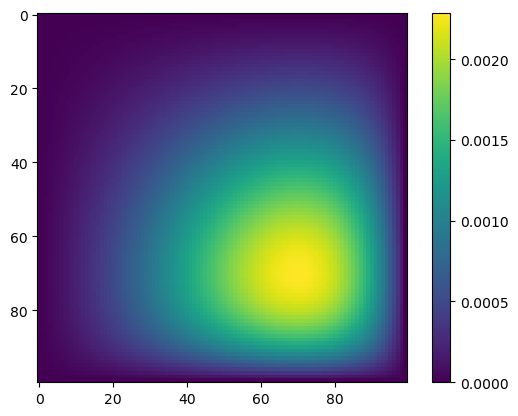

In [5]:
plt.imshow(adr[-1])
plt.colorbar()

In [6]:
np.sum(adr,axis=(1,2))

array([  0.        , 100.        , 100.        , ...,   6.97112468,
         6.96664592,   6.96216999])

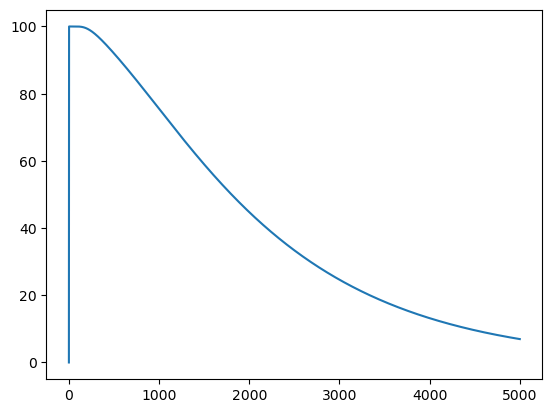

In [7]:
plt.plot(np.sum(adr,axis=(1,2)))

In [8]:
import scipy.stats.qmc as qmc

In [9]:
theta_sampler = qmc.LatinHypercube(d=3)
theta_sample = theta_sampler.random(n=180)

In [10]:
l_bounds = [0,0,0]
u_bounds = [10, 1,1]
theta = qmc.scale(theta_sample, l_bounds, u_bounds)

In [11]:
latent_sampler = qmc.LatinHypercube(d=4)
latent_sample = latent_sampler.random(n=18)

In [12]:
l_bounds = [-0.05,-0.05,0.001,0]
u_bounds = [0.05, 0.05,0.01,1]
latent = qmc.scale(latent_sample, l_bounds, u_bounds)

In [13]:
def computeResponse(delta,length,width,time,latent):
        """
        Computes concentrations.
        Arguments:
         source == forcing function (shape: Nt x Nx x Ny). Can either be generated by ... or determine manually.
         enforce_nonnegative = default False,. Setting to true will force concentration to be non-negative each iteration.
        returns array of concentrations (shape: Nt x Nx x Ny), given source. (also saved it in self.concentration)
        """
        #source = self.source
        
        #get the grid step sizes, their squares and the size of the grid
        
        dt = delta[0]
        dx = delta[1]
        dy = delta[2]
        dx2 = dx**2
        dy2 = dy**2
        Nt = int(time/dt)
        Nx = int(length/dx)
        Ny = int(width/dy)
        c=np.zeros((Nt,Nx,Ny))
        
        source = np.zeros((Nt,Nx,Ny))
        u=[latent[0]*np.ones((Nt,Nx,Ny)),latent[1]*np.ones((Nt,Nx,Ny))]
        source[0,int(Nx/2),int(Ny/2)]=10000000
        source[0,int(Nx/2),int(Ny/4)]=10000000
        source[0,int(Nx/4),int(Ny/2)]=10000000
        source[0,int(Nx/2),int(3*Ny/4)]=10000000
        source[0,int(3*Nx/4),int(Ny/2)]=10000000
        k_0=latent[2]
        R=latent[1]
        c[0,:,:]=0
        for i in range(0,Nt-1):
            # Corner BCs 
            c[i+1,0,0]=0
            c[i+1,Nx-1,Ny-1]=0
            c[i+1,0,Ny-1]=0
            c[i+1,Nx-1,0]=0
    
            c[i+1,1:Nx-1,0]=0
            c[i+1,1:Nx-1,Ny-1]=0 
            #for k in range(1,Ny-1):
                # x edge bcs
            c[i+1,Nx-1,1:Ny-1]=0
            c[i+1,0,1:Ny-1]=0
                # Internal Calc
            c[i+1,1:Nx-1,1:Ny-1]=c[i,1:Nx-1,1:Ny-1] +dt*(source[i,1:Nx-1,1:Ny-1]-u[0][i,1:Nx-1,1:Ny-1]*(c[i,2:Nx,1:Ny-1]-c[i,0:Nx-2,1:Ny-1])/(2*dx) -u[1][i,1:Nx-1,1:Ny-1]*(c[i,1:Nx-1,2:Ny]-c[i,1:Nx-1,0:Ny-2] )/(2*dy) +k_0*(c[i,2:Nx,1:Ny-1]-2*c[i,1:Nx-1,1:Ny-1]  +c[i,0:Nx-2,1:Ny-1])/dx2+k_0*(c[i,1:Nx-1,2:Ny]-2*c[i,1:Nx-1,1:Ny-1]  +c[i,1:Nx-1,0:Ny-2])/dy2 - R*c[i,1:Nx-1,1:Ny-1])

        return c 

In [14]:
theta

array([[1.85682594e+00, 3.62517282e-01, 9.58202493e-01],
       [8.85003608e+00, 6.45636328e-01, 6.88849780e-01],
       [1.70573475e+00, 6.00219199e-01, 3.44291186e-01],
       [8.31514899e+00, 5.58249496e-01, 8.36749108e-02],
       [7.34587876e+00, 1.79966335e-01, 6.24703305e-01],
       [2.67383017e+00, 2.59652015e-01, 9.33427410e-01],
       [6.60661348e+00, 8.71752830e-02, 8.55493456e-01],
       [8.33502727e+00, 9.28484369e-01, 2.22465343e-01],
       [8.17598589e+00, 7.52817833e-01, 4.85514491e-01],
       [1.58547224e+00, 4.23484979e-02, 5.42933335e-01],
       [9.35265985e+00, 3.51900872e-01, 1.92745874e-02],
       [2.63108782e+00, 1.09656397e-01, 5.69589020e-01],
       [8.22816895e+00, 2.83028250e-01, 1.05287492e-01],
       [6.08124457e+00, 9.05039965e-01, 7.60036456e-01],
       [5.79879046e+00, 1.71787822e-01, 8.64359906e-01],
       [5.74041887e+00, 6.39116139e-02, 8.57457528e-01],
       [9.60128554e-02, 3.29213228e-01, 5.27966453e-02],
       [5.09860185e+00, 3.93410

In [15]:
y = np.zeros(180)
response=computeResponse([0.002,0.01,0.01],1,1,10,latent[0])
theta1=(theta/[0.002,0.01,0.01]).astype(int)
y=response[tuple(theta1.T)]
    

In [16]:
1/0.01

100.0

In [17]:
latent[0]

array([-0.03248634,  0.02881244,  0.00487049,  0.25128428])

In [18]:
y.shape

(180,)

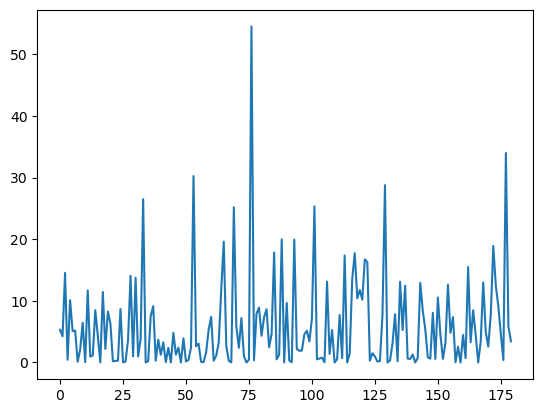

In [19]:
plt.plot(y)

In [20]:
# split original dataset in training, validation and testing sets
X=torch.tensor(theta)
y=torch.tensor(y)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=seed
)

In [21]:
emulator=GPE.ensemble(X_train,y_train[:,None],mean_func='linear')

0


In [22]:
emulator.R2(X_test,y_test[:,None])

/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_score=1-self.MSE(inputVals,outputVals)/torch.tensor(torch.var(outputVals,axis=0))


tensor([0.8855], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [23]:
emulator.predict(X_test)

tensor([[ 0.3745],
        [ 8.5325],
        [ 8.6030],
        [14.3379],
        [ 2.4032],
        [ 5.4950],
        [ 0.0848],
        [ 6.2431],
        [ 9.8060],
        [ 6.0279],
        [ 2.8445],
        [ 0.7581],
        [ 3.6345],
        [12.5798],
        [14.0577],
        [ 7.4817],
        [-0.1547],
        [ 1.4966]], grad_fn=<PermuteBackward0>)

In [24]:
y_test

tensor([ 0.6290,  7.5660,  4.9540, 12.9203,  0.1630,  7.8405,  0.5088,  3.8201,
        10.1900,  5.3981,  0.2648,  1.4377,  3.2707, 11.7564, 17.8500,  7.7151,
         0.0000,  0.7088], dtype=torch.float64)

In [25]:
latent

array([[-3.24863383e-02,  2.88124356e-02,  4.87049262e-03,
         2.51284284e-01],
       [ 3.54623049e-03, -3.34510149e-02,  6.45394781e-03,
         8.23493689e-01],
       [ 4.83243791e-02,  7.57237334e-03,  1.34862010e-03,
         1.61549977e-01],
       [-5.32549059e-04,  3.33589940e-02,  6.61005527e-03,
         4.04676592e-02],
       [ 4.21011666e-02, -2.41808861e-02,  2.88173968e-03,
         9.08936571e-01],
       [ 8.48364993e-03, -4.15624358e-02,  8.64558300e-03,
         5.15394025e-01],
       [ 2.72218699e-02, -1.33826903e-02,  7.46385842e-03,
         6.18533168e-01],
       [-2.00501688e-02, -2.34855923e-03,  8.31787493e-03,
         5.89491205e-01],
       [-8.89252133e-03,  1.54840458e-02,  4.08100156e-03,
         1.67472615e-01],
       [ 2.86108686e-02,  2.50864491e-02,  3.98363624e-03,
         3.96808444e-01],
       [ 1.31272219e-02,  1.92534829e-02,  7.81926739e-03,
         3.33482701e-01],
       [-3.50877610e-02, -1.05422912e-02,  5.22991814e-03,
      

In [26]:
inputs=[]
for i,l in enumerate(latent):
    theta_sampler = qmc.LatinHypercube(d=3)
    theta_sample = theta_sampler.random(n=180)
    l_bounds = [1,0.1,0.1]
    u_bounds = [9, 0.9,0.9]
    theta = qmc.scale(theta_sample, l_bounds, u_bounds)
    theta = qmc.scale(theta_sample, l_bounds, u_bounds)
    inputs.append(theta)

In [27]:
outputs = []
for i,l in enumerate(latent):
    response = computeResponse([0.002,0.01,0.01],1,1,10,l)
    theta=(inputs[i]/[0.002,0.01,0.01]).astype(int)
    outputs.append(response[tuple(theta.T)])

In [28]:
y_train[:,None].shape

torch.Size([162, 1])

In [29]:
R2_mean = np.zeros((1,len(inputs)) )
R2_std = np.zeros((1,len(inputs))) 
for i in range(len(inputs)):
    
    # split original dataset in training, validation and testing sets
    X=torch.tensor(inputs[i]).float()
    y=torch.tensor(outputs[i]).float()
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y[:,None],
        test_size=0.1,
        random_state=seed
    )
    emulator=GPE.ensemble(X_train,y_train,mean_func='linear',training_iter=1000)
    mean,std=emulator.R2_sample(X_test,y_test)
    R2_mean[:,i]=mean
    R2_std[:,i]=std

0


/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:187: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  prediction=torch.stack(prediction).T
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:216: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2_mean = torch.tensor(R2_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPE_ensemble.py:217: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone(

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [30]:
R2_mean.shape

(1, 18)

In [31]:
R2_mean

array([[0.95943135, 0.96464604, 0.80709851, 0.98204279, 0.89229107,
        0.99471188, 0.91740119, 0.98310792, 0.87973011, 0.93287694,
        0.99445498, 0.98399562, 0.99585599, 0.96818113, 0.97010648,
        0.82710856, 0.99606389, 0.97160566]])

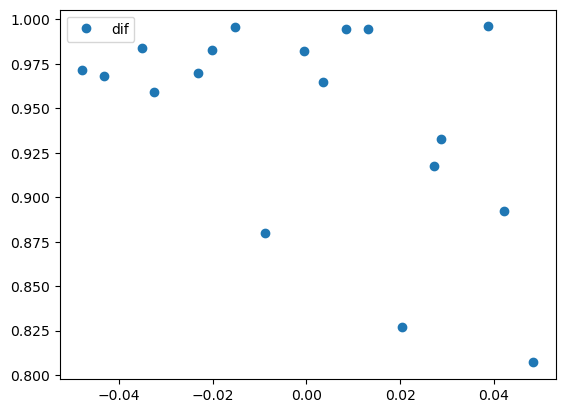

In [32]:
plt.plot(latent[:,0],R2_mean.T,'o')
plt.legend(['dif','end','mean'])

In [46]:
large_input = np.array(inputs).reshape(18*180,3)

modeweights = np.repeat(latent,180,axis=0)

large_input = np.concatenate((large_input,modeweights),axis=1)

large_output = np.array(outputs).reshape(18*180,1)

In [47]:
latent

array([[-3.24863383e-02,  2.88124356e-02,  4.87049262e-03,
         2.51284284e-01],
       [ 3.54623049e-03, -3.34510149e-02,  6.45394781e-03,
         8.23493689e-01],
       [ 4.83243791e-02,  7.57237334e-03,  1.34862010e-03,
         1.61549977e-01],
       [-5.32549059e-04,  3.33589940e-02,  6.61005527e-03,
         4.04676592e-02],
       [ 4.21011666e-02, -2.41808861e-02,  2.88173968e-03,
         9.08936571e-01],
       [ 8.48364993e-03, -4.15624358e-02,  8.64558300e-03,
         5.15394025e-01],
       [ 2.72218699e-02, -1.33826903e-02,  7.46385842e-03,
         6.18533168e-01],
       [-2.00501688e-02, -2.34855923e-03,  8.31787493e-03,
         5.89491205e-01],
       [-8.89252133e-03,  1.54840458e-02,  4.08100156e-03,
         1.67472615e-01],
       [ 2.86108686e-02,  2.50864491e-02,  3.98363624e-03,
         3.96808444e-01],
       [ 1.31272219e-02,  1.92534829e-02,  7.81926739e-03,
         3.33482701e-01],
       [-3.50877610e-02, -1.05422912e-02,  5.22991814e-03,
      

In [48]:
latent2=latent.copy()
np.delete(latent2,0)

array([ 2.88124356e-02,  4.87049262e-03,  2.51284284e-01,  3.54623049e-03,
       -3.34510149e-02,  6.45394781e-03,  8.23493689e-01,  4.83243791e-02,
        7.57237334e-03,  1.34862010e-03,  1.61549977e-01, -5.32549059e-04,
        3.33589940e-02,  6.61005527e-03,  4.04676592e-02,  4.21011666e-02,
       -2.41808861e-02,  2.88173968e-03,  9.08936571e-01,  8.48364993e-03,
       -4.15624358e-02,  8.64558300e-03,  5.15394025e-01,  2.72218699e-02,
       -1.33826903e-02,  7.46385842e-03,  6.18533168e-01, -2.00501688e-02,
       -2.34855923e-03,  8.31787493e-03,  5.89491205e-01, -8.89252133e-03,
        1.54840458e-02,  4.08100156e-03,  1.67472615e-01,  2.86108686e-02,
        2.50864491e-02,  3.98363624e-03,  3.96808444e-01,  1.31272219e-02,
        1.92534829e-02,  7.81926739e-03,  3.33482701e-01, -3.50877610e-02,
       -1.05422912e-02,  5.22991814e-03,  8.32538657e-02, -1.52127449e-02,
        4.50296642e-02,  9.11025190e-03,  9.52544038e-01, -4.32251107e-02,
       -4.84063649e-02,  

In [49]:
latent2=latent.copy()
latent2=np.delete(latent2,0,axis=0)

In [50]:
latent2

array([[ 3.54623049e-03, -3.34510149e-02,  6.45394781e-03,
         8.23493689e-01],
       [ 4.83243791e-02,  7.57237334e-03,  1.34862010e-03,
         1.61549977e-01],
       [-5.32549059e-04,  3.33589940e-02,  6.61005527e-03,
         4.04676592e-02],
       [ 4.21011666e-02, -2.41808861e-02,  2.88173968e-03,
         9.08936571e-01],
       [ 8.48364993e-03, -4.15624358e-02,  8.64558300e-03,
         5.15394025e-01],
       [ 2.72218699e-02, -1.33826903e-02,  7.46385842e-03,
         6.18533168e-01],
       [-2.00501688e-02, -2.34855923e-03,  8.31787493e-03,
         5.89491205e-01],
       [-8.89252133e-03,  1.54840458e-02,  4.08100156e-03,
         1.67472615e-01],
       [ 2.86108686e-02,  2.50864491e-02,  3.98363624e-03,
         3.96808444e-01],
       [ 1.31272219e-02,  1.92534829e-02,  7.81926739e-03,
         3.33482701e-01],
       [-3.50877610e-02, -1.05422912e-02,  5.22991814e-03,
         8.32538657e-02],
       [-1.52127449e-02,  4.50296642e-02,  9.11025190e-03,
      

In [51]:
R2_in = torch.zeros((18,1))
R2_out = torch.zeros((18,1))

for i in range(18):
    
    
    
    large_input = np.array(inputs[0:i]+inputs[i+1:18]).reshape(17*180,3)

    latent2=latent.copy()
    latent2=np.delete(latent2,i,axis=0)

    modeweights = np.repeat(latent2,180,axis=0)

    large_input = np.concatenate((large_input,modeweights),axis=1)

    large_output = np.array(outputs[0:i]+outputs[i+1:18]).reshape(17*180,1)
    
    leftout_input=torch.tensor(np.concatenate((inputs[i],np.repeat(latent[[i]],180,axis=0)),axis=1))
    leftout_output=torch.tensor(outputs[i])
    
    # split original dataset in training, validation and testing sets
    X=torch.tensor(large_input)
    y=torch.tensor(large_output)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=720,
        random_state=seed
    )

    emulator=GPE.ensemble(X_train,y_train,mean_func='linear',training_iter=1000)

    R2_in[i]=emulator.R2(X_test,y_test)

    R2_out[i]=emulator.R2(leftout_input,leftout_output[:,None])
    print(R2_out[i])

0
tensor([0.9422], grad_fn=<SelectBackward0>)
0
tensor([0.8785], grad_fn=<SelectBackward0>)
0
tensor([0.6429], grad_fn=<SelectBackward0>)
0
tensor([0.9435], grad_fn=<SelectBackward0>)
0
tensor([0.8200], grad_fn=<SelectBackward0>)
0
tensor([0.9126], grad_fn=<SelectBackward0>)
0
tensor([0.9670], grad_fn=<SelectBackward0>)
0
tensor([0.9297], grad_fn=<SelectBackward0>)
0
tensor([0.9222], grad_fn=<SelectBackward0>)
0
tensor([0.8267], grad_fn=<SelectBackward0>)
0
tensor([0.9658], grad_fn=<SelectBackward0>)
0
tensor([0.9563], grad_fn=<SelectBackward0>)
0
tensor([0.8626], grad_fn=<SelectBackward0>)
0
tensor([0.6614], grad_fn=<SelectBackward0>)
0
tensor([0.8084], grad_fn=<SelectBackward0>)
0
tensor([0.6768], grad_fn=<SelectBackward0>)
0
tensor([0.9334], grad_fn=<SelectBackward0>)
0
tensor([0.9538], grad_fn=<SelectBackward0>)


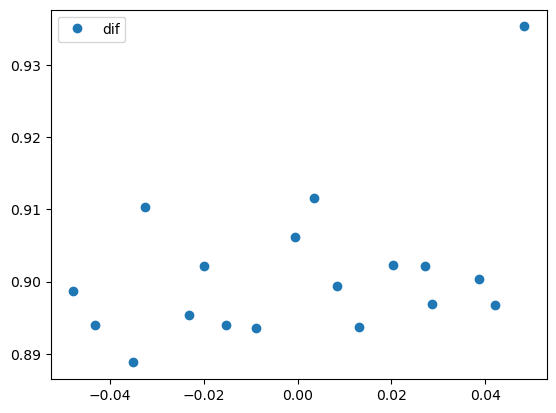

In [52]:
plt.plot(latent[:,0],R2_in.detach().numpy(),'o')
plt.legend(['dif','end','mean'])

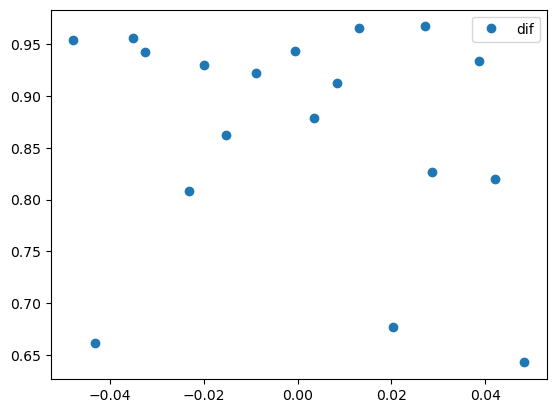

In [53]:
plt.plot(latent[:,0],R2_out[:,0].detach().numpy(),'o')
plt.legend(['dif','end','mean'])

In [54]:
inputs.copy()

[array([[1.32635219, 0.29791694, 0.25577377],
        [6.61471279, 0.31014789, 0.82171314],
        [6.1807911 , 0.874782  , 0.60057884],
        [3.29665722, 0.76437295, 0.1549364 ],
        [6.22387196, 0.65638683, 0.76834279],
        [6.25687115, 0.5251715 , 0.77190535],
        [4.82555719, 0.40126294, 0.66940563],
        [4.87894949, 0.49007259, 0.48393789],
        [4.63069141, 0.53553296, 0.89744388],
        [5.28197057, 0.8886455 , 0.11848853],
        [8.64643902, 0.6335251 , 0.88258948],
        [4.00358039, 0.6992732 , 0.3601286 ],
        [7.55633473, 0.18988519, 0.80735941],
        [5.84258983, 0.74599228, 0.84665754],
        [1.12864003, 0.80081413, 0.26475777],
        [5.11134402, 0.67231925, 0.28152428],
        [1.60542699, 0.86004325, 0.35020661],
        [6.46293914, 0.10866927, 0.83692346],
        [6.70031881, 0.71875301, 0.5484606 ],
        [3.95595655, 0.19806115, 0.60363056],
        [5.31574416, 0.36935829, 0.43549243],
        [6.52961545, 0.45037097, 0

In [55]:
t_size = 100
reps = 5
MSE = np.zeros((18,17,3))
R2 = np.zeros((18,17,3))
for i in range(18):

    X0 = torch.tensor(inputs[i])
    Y0 = torch.tensor(outputs[i])[:,None]
    emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)
    
    inputs2 = inputs.copy()
    inputs2.pop(i)
    outputs2 = outputs.copy()
    outputs2.pop(i)
    
    for j in (range(17)):
        inputData_1 = inputs2[j]
        outputData_1 = outputs2[j]

        X1 = torch.tensor(inputData_1)
        Y1 = torch.tensor(outputData_1)[:,None]
        # split original dataset in training, validation and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X1,
            Y1,
            test_size=0.1,
            random_state=seed
        )
        for k in range(reps):
            a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)
            m0 = emulator_0.predict(X_train[a,:])
            y_adjust = torch.tensor(y_train[a] - m0)
            delta_1 = GPE.ensemble(X_train[a,:],y_adjust,mean_func="linear",training_iter=500)
            MSE[i,j,:] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2[i,j,:] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps



0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_38071/3901179890.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_38071/3901179890.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE[i,j,:] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_38071/3901179890.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2[i,j,:] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [56]:
latent[:,0]

array([-0.03248634,  0.00354623,  0.04832438, -0.00053255,  0.04210117,
        0.00848365,  0.02722187, -0.02005017, -0.00889252,  0.02861087,
        0.01312722, -0.03508776, -0.01521274, -0.04322511, -0.02304693,
        0.02031137,  0.03877375, -0.04781842])

In [57]:
R2.mean(axis=1)[:,2]

array([0.94799682, 0.94767473, 0.65039754, 0.95886391, 0.78287888,
       0.95555809, 0.95713485, 0.96116936, 0.96273535, 0.94447895,
       0.95619745, 0.95211628, 0.9638953 , 0.90883961, 0.90579848,
       0.75031154, 0.96064966, 0.95886537])

Text(0, 0.5, '$R^2$')

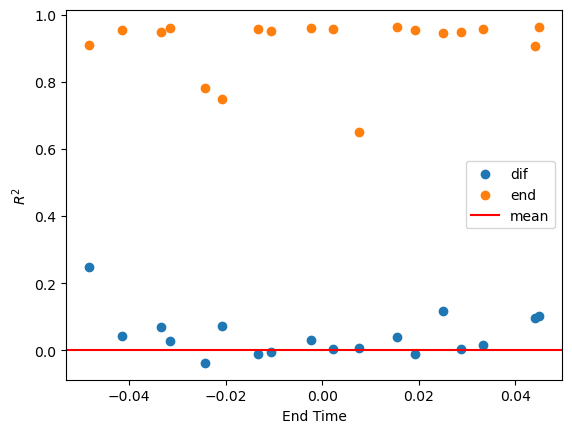

In [58]:
fig, ax = plt.subplots()


#ax.scatter(latent[:,0],R2.mean(axis=1)[:,0]-R2_out.detach().numpy()[:,0])
#ax.scatter(latent[:,0],R2.mean(axis=1)[:,1]-R2_out.detach().numpy()[:,1])
ax.scatter(latent[:,1],R2.mean(axis=1)[:,0]-R2_out.detach().numpy()[:,0])
ax.scatter(latent[:,1],R2.mean(axis=1)[:, 0])
plt.axhline(y=0, color='r', linestyle='-')
#ax.scatter(latent[9:,0],R2_out.detach().numpy()[9:,2])

#ax.scatter(latent,R2.mean(axis=1)[:,1])
#ax.scatter(latent,R2_out.detach().numpy()[:,1])

#ax.scatter(latent,R2.mean(axis=1)[:,2])
#ax.scatter(latent,R2_out.detach().numpy()[:,2])

#plt.errorbar(latent,R2.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])


#ax.scatter(latent,R2.mean(axis=1)[:,1])
#plt.errorbar(latent,R2.mean(axis=1)[:,1],fmt='o',yerr=R2.std(axis=1)[:,1])


#ax.scatter(latent,R2.mean(axis=1)[:,2])
#plt.errorbar(latent,R2.mean(axis=1)[:,2],fmt='o',yerr=R2.std(axis=1)[:,2])


plt.legend(['dif','end','mean'])
plt.xlabel('End Time')
plt.ylabel('$R^2$')

Text(0, 0.5, '$R^2$')

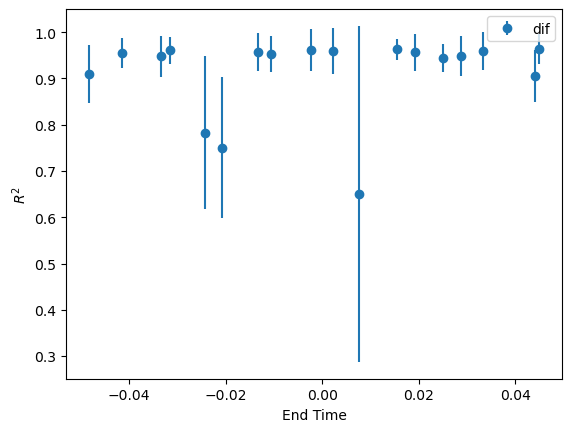

In [59]:

ax.scatter(latent[:,1],R2.mean(axis=1)[:,0])
plt.errorbar(latent[:,1],R2.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])


plt.legend(['dif','end','mean'])
plt.xlabel('End Time')
plt.ylabel('$R^2$')
#plt.yscale('log')

In [60]:
for i in outputs:
    print(i.max())

31.11357923410769
30.304452686102767
47.480178622429165
27.77449054320626
40.21065523764406
27.441905858711863
26.082096050644687
24.438129464640856
29.313873972843812
32.33768229115401
24.293659598100103
29.132751714746696
20.45391000026769
35.36196201103818
28.050123867464976
50.04628887289406
23.653284862377955
29.705588809856557


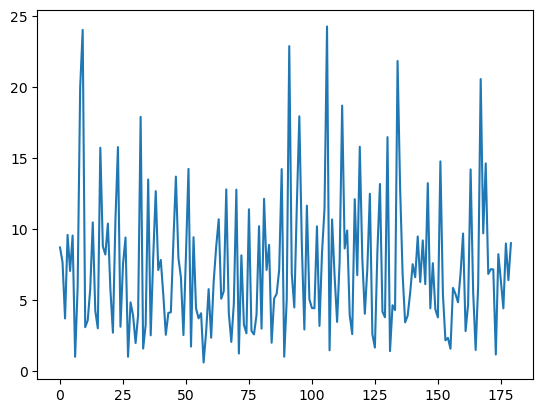

In [61]:
plt.plot(outputs[10])

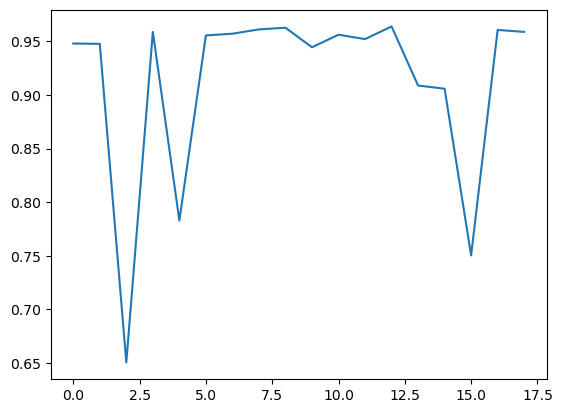

In [62]:
plt.plot(R2.mean(axis=1)[:,0])

In [63]:
X0 = torch.tensor(inputs[0])
Y0 = torch.tensor(outputs[0])[:,None]
emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)

0


In [64]:
#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE = np.zeros((n,m,3))
R2 = np.zeros((n,m,3))
reps = 1
for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
            emulator_0 = GPE.ensemble(X0[a,:],Y0[a,:],mean_func="linear",training_iter=500)
            m0 = emulator_0.predict(X_train[b,:])
            y_adjust = torch.tensor(y_train[b] - m0)
            delta_1 = GPE.ensemble(X_train[b,:],y_adjust,mean_func="linear",training_iter=500)
            MSE[i,k] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2[i,k] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_38071/2018170924.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[b] - m0)


0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_38071/2018170924.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE[i,k] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_38071/2018170924.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2[i,k] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


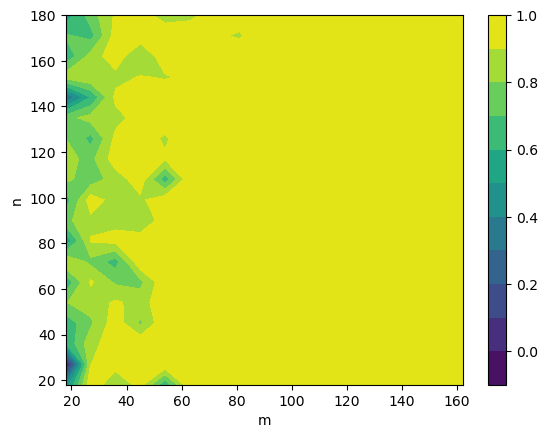

In [65]:
x = np.linspace(9,162,18)

x

y = np.linspace(9,180,20)

y

xx,yy=np.meshgrid(x,y)

xx[1:,1:].shape

level = 1

plt.contourf(xx[level:,level:],yy[level:,level:],R2[level:,level:,0],origin='lower',levels=10)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()

In [66]:

ax.scatter(latent[:,1],R2.mean(axis=1)[:,1])
plt.errorbar(latent[:,1],R2.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])


ax.scatter(latent[:,1],R2.mean(axis=1)[:,1])
plt.errorbar(latent[:,1],R2.mean(axis=1)[:,1],fmt='o',yerr=R2.std(axis=1)[:,1])


ax.scatter(latent[:,1],R2.mean(axis=1)[:,2])
plt.errorbar(latent[:,1],R2.mean(axis=1)[:,2],fmt='o',yerr=R2.std(axis=1)[:,2])


plt.legend(['dif','end','mean'])
plt.xlabel('End Time')
plt.ylabel('$R^2$')
#plt.yscale('log')

ValueError: x and y must be the same size